In [1]:
!pip install -U d2l transformers

     |████████████████████████████████| 82 kB 557 kB/s 
     |████████████████████████████████| 4.0 MB 32.7 MB/s 
     |████████████████████████████████| 61 kB 7.3 MB/s 
     |████████████████████████████████| 11.2 MB 22.6 MB/s 
     |████████████████████████████████| 9.9 MB 34.4 MB/s 
     |████████████████████████████████| 15.7 MB 30.5 MB/s 
     |████████████████████████████████| 930 kB 39.7 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 6.6 MB 37.2 MB/s 
     |████████████████████████████████| 596 kB 46.2 MB/s 
     |████████████████████████████████| 880 kB 39.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=29d34b24540f165e22a2cf344694aa2a935ba05c7c31045adb0f91c2be915dd3
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: requests
    Found existing installation: req

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime

import os
import re

from d2l import torch as d2l

from transformers import BertTokenizer, BertForSequenceClassification

import torch
from torch import nn
from torch.nn.functional import softmax
from torchvision.datasets.utils import download_and_extract_archive
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report

In [2]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_DIR = "/content/drive/My Drive/ai/lab3/"

else:
    DATA_DIR = "./data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp drive/MyDrive/ai/lab2/pytorchtools.py .
from pytorchtools import EarlyStopping  # from https://github.com/Bjarten/early-stopping-pytorch

# Dataset preprocessing

In [4]:
class DrugLib(Dataset):
  def __init__(self, root, train, task):
    self.root = os.path.join(root, "drugLib") 
    self.task = task # overall | effectiveness | sideEffects

    self.download()

    if not self._check_integrity():
      raise RuntimeError("Dataset not found or corrupted.")

    self.load(train)

  def download(self) -> None:
    if self._check_integrity():
        print("Files already downloaded and verified")
        return

    download_and_extract_archive(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00461/drugLib_raw.zip",
        self.root,
        md5="b4f5b49c9ddb7b6f466928e1f49ad23f",
        filename="drugLib_raw.zip"
    )

  def _check_integrity(self) -> bool:
    return os.path.exists(os.path.join(self.root, "drugLibTrain_raw.tsv")) and os.path.exists(os.path.join(self.root, "drugLibTest_raw.tsv"))

  def load(self, train):
    if train:
      self.df = pd.read_csv(os.path.join(self.root, "drugLibTrain_raw.tsv"), sep="\t", header=0)
    else:
      self.df = pd.read_csv(os.path.join(self.root, "drugLibTest_raw.tsv"), sep="\t", header=0)

    self.df = self.df.dropna()


    effMap = {'Ineffective':0, 'Marginally Effective':1, 'Moderately Effective':1, 'Considerably Effective':2,
                         'Highly Effective':2}
    sideEffectsMap = {'No Side Effects':0, 'Mild Side Effects':1, 'Moderate Side Effects':1, 'Severe Side Effects':2, 'Extremely Severe Side Effects':2}

    self.df["rating"] = self.df["rating"].apply(lambda x: 0 if x <= 4 else (1 if x < 7 else 2))

    self.df["effectiveness"] = self.df["effectiveness"].apply(lambda x: effMap[x])
    self.df["sideEffects"] = self.df["sideEffects"].apply(lambda x: sideEffectsMap[x])

    def proccess(txt):
      # replace all whitespaces to 1 space; delte ., and etc. All to lower
      return re.sub("[^a-zA-Z\s]", "",  re.sub('[\s]+', ' ', txt)).lower()

    self.df["benefitsReview"] = self.df["benefitsReview"].apply(proccess)
    self.df["sideEffectsReview"] = self.df["sideEffectsReview"].apply(proccess)
    self.df["commentsReview"] = self.df["commentsReview"].apply(proccess)

    if self.task == "overall":
      self.labels = self.df["rating"]
      self.data = self.df[["benefitsReview", "sideEffectsReview", "commentsReview"]].apply(lambda x: " ".join(x), axis=1)
      self.review_len = 300
    elif self.task == "effectiveness":
      self.labels = self.df["effectiveness"]
      self.data = self.df["benefitsReview"]
      self.review_len = 200
    elif self.task == "sideEffects":
      self.labels = self.df["sideEffects"]
      self.data = self.df["sideEffectsReview"]
      self.review_len = 200
    else:
      raise ValueError("Bad task!")


    self.tokens = d2l.tokenize(self.data, token="word")

    self.vocab = d2l.Vocab(self.tokens, min_freq=5, reserved_tokens=["<pad>"])

    uniq_label, counts = np.unique(self.labels.values, return_counts=True)
    class_weights = [sum(counts) / c for c in counts]
    labels_weights = [class_weights[i] for i in self.labels.values]

    self.sampler = WeightedRandomSampler(labels_weights, len(self.labels))

    self.data = torch.tensor([d2l.truncate_pad(self.vocab[line], self.review_len, self.vocab['<pad>']) for line in self.tokens])
    self.labels = torch.tensor(self.labels.values)

  
  def __len__(self):
        return len(self.df)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

# Common (Training functions, models class)

In [4]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, num_out_classes, recurrent_layer=nn.LSTM, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = recurrent_layer(embed_size,
                               num_hiddens,
                               num_layers=num_layers,
                               bidirectional=True,
                               dropout=0.25)
        self.decoder = nn.Linear(4 * num_hiddens, num_out_classes)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps).
        # The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully-connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        outs = self.decoder(encoding)
        return softmax(outs)

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) in [nn.LSTM, nn.RNN, nn.GRU]:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])


In [6]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [7]:
def initNet(net, vocab):
  net.apply(init_weights);

  embeds = glove_embedding[vocab.idx_to_token]
  net.embedding.weight.data.copy_(embeds)
  net.embedding.weight.requires_grad = False

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    total_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to("cuda"), y.to("cuda")
        optimizer.zero_grad()

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        total_loss += float(loss.item())
        if batch % 20 == 0:
            loss, current = float(loss.item()), (batch +1) * len(X)
            print(f"Accuracy: {(100 * correct / current):>0.1f}%, Avg loss: {loss:>7f},\t[{current:>5d}/{size:>5d}]")
    
    lossTrain = total_loss/len(dataloader)
    accuracyTrain = 100 * correct / size

    print(f"Train accuracy: {accuracyTrain:>0.1f}%, Avg loss: {lossTrain:>7f} ")

    print(f"Memory allocated: {(torch.cuda.memory_allocated()/1024/1024):.1f} MB")

    return lossTrain, accuracyTrain

In [9]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        model.eval()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to("cuda"), y.to("cuda")

            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += float(loss.item())
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            if batch % 20 == 0:
              loss, current = loss.item(), batch * len(X)
              print(f"Test loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    test_loss /= num_batches
    correct /= size

    accuracyTest = 100 * correct

    print(f"Test Error: \n Accuracy: {accuracyTest:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Memory allocated: {(torch.cuda.memory_allocated()/1024/1024):.1f} MB")

    return test_loss, accuracyTest

In [10]:
def predict(model, dataloader):
  y_pred = []
  y_true = []
  confidence = []

  size = len(dataloader.dataset)

  with torch.no_grad():
    model.eval()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to("cuda")
        pred = model(X)

        y_true.append(y.numpy())
        y_pred_t = pred.argmax(1).cpu().numpy()

        y_pred.append(y_pred_t)
        confidence.append(softmax(pred).cpu().numpy())

        if batch % 20 == 0:
          current = batch * len(X)
          print(f"Test:  [{current:>5d}/{size:>5d}]")

  y_pred = np.concatenate([i.squeeze() for i in y_pred])
  y_true = np.concatenate([i.squeeze() for i in y_true])
  confidence = np.concatenate([i.squeeze() for i in confidence])

  return y_pred, y_true, confidence

In [11]:
def plot_learning_curves(name, test_loss, train_loss, test_accuracy, train_accuracy):
    plt.subplot(121)

    plt.plot(train_accuracy, label="train", c="tab:blue")
    plt.plot(test_accuracy, label="test", c="tab:red")

    plt.title(f"{name}\naccuracy")
    plt.ylabel("%")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    # plt.xlim(0, len(history))

    plt.subplot(122)
    plt.plot(train_loss, label="train", c="tab:blue")
    plt.plot(test_loss, label="test", c="tab:red")

    plt.title(f"{name}\nloss (CrossEntropyLoss)")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    # plt.xlim(0, len(history))
    plt.ylim(0)
    plt.tight_layout()
    plt.show()

In [12]:
def train_and_plot_lc(net, name, trainDataloader, testDataloader, loss_fn, optimizer, epochs = 10, train_loop_func=train_loop, test_loop_func=test_loop):
  early_stopping = EarlyStopping(patience=3, verbose=True)

  test_loss = []
  train_loss = []
  test_accuracy = []
  train_accuracy = []

  for t in range(epochs):
      print(f"Epoch {t + 1}\n-------------------------------")
      print(f"Memory allocated: {(torch.cuda.memory_allocated()/1024/1024):.1f} MB")
      lossTrain, accuracyTrain = train_loop_func(trainDataloader, net, loss_fn, optimizer)
      lossTest, accuracyTest = test_loop_func(testDataloader, net, loss_fn)

      test_loss += [lossTest]
      train_loss += [lossTrain]
      test_accuracy += [accuracyTest]
      train_accuracy += [accuracyTrain]

      early_stopping(lossTest, net)

      torch.save(net.state_dict(), f"{DATA_DIR}{name}-{t}.pth")
      if early_stopping.early_stop:
          print(f"Early stopping, epoch {t + 1}")
          break

  print(f"Done! {name} trained.")

  plot_learning_curves(name, test_loss, train_loss, test_accuracy, train_accuracy)

In [30]:
def metrics(net, testDataloader, task="overall", predict_func=predict):
  y_pred, y_true, confidence = predict_func(net, testDataloader)

  target_names = {"overall": ["rating <= 4", "4 < rating < 7", "rating >= 7"],
                  "effectiveness": ["Ineffective", "Marginally/Moderately Effective", "Considerably/Highly Effective"],
                  "sideEffects": ["No Side Effects", "Mild/Moderate Side Effects", "Severe/Extremely Severe  Side Effects"]}

  print(classification_report(y_true, y_pred, target_names=target_names[task]))

  print("\n\nAccuracy:", accuracy_score(y_true, y_pred))
  print("Balanced_accuracy:", balanced_accuracy_score(y_true, y_pred))
  print("F1:", f1_score(y_true, y_pred, average='macro'))
  print("Roc_auc:", roc_auc_score(y_true, confidence, multi_class='ovr'))
  print("Precision:", precision_score(y_true, y_pred, average='macro'))
  print("Recall:", recall_score(y_true, y_pred, average='macro'))

# Overall rating


In [21]:
overallTestDataset = DrugLib(DATA_DIR, train=False, task="overall")
overallTrainDataset = DrugLib(DATA_DIR, train=True, task="overall")

overallTestDataloader = DataLoader(overallTestDataset, batch_size=64)
overallTrainDataloader = DataLoader(overallTrainDataset, sampler=overallTrainDataset.sampler, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


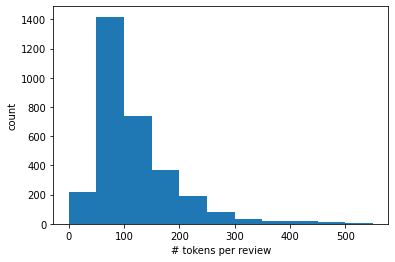

In [ ]:
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in overallTrainDataset.tokens], bins=range(0, 600, 50))
plt.show()

Trim all reviews up to 300 chars

## RNN

In [41]:
embed_size, num_hiddens, num_layers = 100, 64, 2
rnn_overall = BiRNN(len(overallTrainDataset.vocab), embed_size, num_hiddens, num_layers, 3, nn.RNN).to("cuda")
initNet(rnn_overall, overallTrainDataset.vocab)

Epoch 1
-------------------------------
Memory allocated: 10.7 MB
Accuracy: 45.3%, Avg loss: 1.080992,	[   64/ 3096]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 37.9%, Avg loss: 1.087921,	[ 1344/ 3096]
Accuracy: 38.9%, Avg loss: 0.998964,	[ 2624/ 3096]
Train accuracy: 39.7%, Avg loss: 1.128962 
Memory allocated: 9.9 MB
Test loss: 1.327464  [    0/ 1036]
Test Error: 
 Accuracy: 19.5%, Avg loss: 1.340703 

Memory allocated: 9.9 MB
Validation loss decreased (inf --> 1.340703).  Saving model ...
Epoch 2
-------------------------------
Memory allocated: 9.9 MB
Accuracy: 40.6%, Avg loss: 1.117382,	[   64/ 3096]
Accuracy: 43.4%, Avg loss: 1.059644,	[ 1344/ 3096]
Accuracy: 42.4%, Avg loss: 1.048896,	[ 2624/ 3096]
Train accuracy: 42.1%, Avg loss: 1.112589 
Memory allocated: 9.9 MB
Test loss: 1.188204  [    0/ 1036]
Test Error: 
 Accuracy: 26.9%, Avg loss: 1.265919 

Memory allocated: 9.9 MB
Validation loss decreased (1.340703 --> 1.265919).  Saving model ...
Epoch 3
-------------------------------
Memory allocated: 9.9 MB
Accuracy: 37.5%, Avg loss: 1.156043,	[   64/ 3096]
Accuracy: 38.3%, Avg loss: 1.185206,	[ 1344/ 3096]
Accuracy: 40.2%, Avg

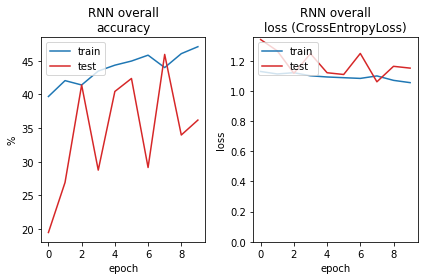

In [42]:
loss_fn = nn.CrossEntropyLoss().to("cuda")
optimizer = Adam(rnn_overall.parameters(), lr=0.01)

train_and_plot_lc(rnn_overall, "RNN overall", overallTrainDataloader, overallTestDataloader, loss_fn, optimizer, epochs = 10)

In [43]:
rnn_overall.load_state_dict(torch.load(f"{DATA_DIR}RNN overall-7.pth"))
metrics(rnn_overall, overallTestDataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test:  [    0/ 1036]
                precision    recall  f1-score   support

   rating <= 4       0.27      0.38      0.31       241
4 < rating < 7       0.11      0.10      0.11       125
   rating >= 7       0.64      0.56      0.60       670

      accuracy                           0.46      1036
     macro avg       0.34      0.35      0.34      1036
  weighted avg       0.49      0.46      0.47      1036



Accuracy: 0.4594594594594595
Balanced_accuracy: 0.34560574719762177
F1: 0.33873868374377264
Roc_auc: 0.5101378130210931
Precision: 0.34058315092640856
Recall: 0.34560574719762177


## GRU

In [31]:
embed_size, num_hiddens, num_layers = 100, 64, 2
gru_overall = BiRNN(len(overallTrainDataset.vocab), embed_size, num_hiddens, num_layers, 3, nn.GRU).to("cuda")
initNet(gru_overall, overallTrainDataset.vocab)

Epoch 1
-------------------------------
Memory allocated: 9.7 MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 31.2%, Avg loss: 1.102310,	[   64/ 3096]
Accuracy: 41.7%, Avg loss: 1.049456,	[ 1344/ 3096]
Accuracy: 44.8%, Avg loss: 0.885372,	[ 2624/ 3096]
Train accuracy: 45.7%, Avg loss: 1.044045 
Memory allocated: 7.7 MB
Test loss: 1.167955  [    0/ 1036]
Test Error: 
 Accuracy: 29.5%, Avg loss: 1.191159 

Memory allocated: 7.7 MB
Validation loss decreased (inf --> 1.191159).  Saving model ...
Epoch 2
-------------------------------
Memory allocated: 7.7 MB
Accuracy: 37.5%, Avg loss: 1.126403,	[   64/ 3096]
Accuracy: 52.0%, Avg loss: 1.057804,	[ 1344/ 3096]
Accuracy: 57.1%, Avg loss: 0.885020,	[ 2624/ 3096]
Train accuracy: 56.8%, Avg loss: 0.962150 
Memory allocated: 7.7 MB
Test loss: 1.162833  [    0/ 1036]
Test Error: 
 Accuracy: 31.9%, Avg loss: 1.194088 

Memory allocated: 7.7 MB
EarlyStopping counter: 1 out of 3
Epoch 3
-------------------------------
Memory allocated: 7.7 MB
Accuracy: 53.1%, Avg loss: 1.014631,	[   64/ 3096]
Accuracy: 62.7%, Avg loss: 0.853494,	[ 1344/ 3096]
Accu

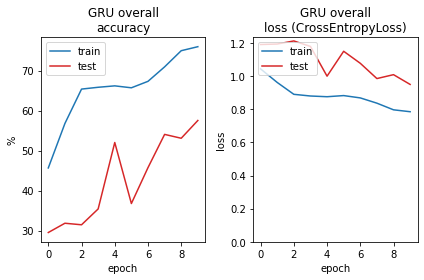

In [32]:
loss_fn = nn.CrossEntropyLoss().to("cuda")
optimizer = Adam(gru_overall.parameters(), lr=0.01)

train_and_plot_lc(gru_overall, "GRU overall", overallTrainDataloader, overallTestDataloader, loss_fn, optimizer, epochs = 10)

In [33]:
gru_overall.load_state_dict(torch.load(f"{DATA_DIR}GRU overall-9.pth"))
metrics(gru_overall, overallTestDataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test:  [    0/ 1036]
                precision    recall  f1-score   support

   rating <= 4       0.33      0.27      0.29       241
4 < rating < 7       0.13      0.05      0.07       125
   rating >= 7       0.66      0.79      0.72       670

      accuracy                           0.58      1036
     macro avg       0.37      0.37      0.36      1036
  weighted avg       0.52      0.58      0.54      1036



Accuracy: 0.5752895752895753
Balanced_accuracy: 0.3662115976135918
F1: 0.36070301754168294
Roc_auc: 0.5641023119545839
Precision: 0.37306390060345535
Recall: 0.3662115976135918


## LSTM

In [35]:
embed_size, num_hiddens, num_layers = 100, 64, 2
lstm_overall = BiRNN(len(overallTrainDataset.vocab), embed_size, num_hiddens, num_layers, 3, nn.LSTM).to("cuda")
initNet(lstm_overall, overallTrainDataset.vocab)

Epoch 1
-------------------------------
Memory allocated: 9.9 MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 28.1%, Avg loss: 1.100326,	[   64/ 3096]
Accuracy: 38.8%, Avg loss: 1.027839,	[ 1344/ 3096]
Accuracy: 44.3%, Avg loss: 1.024462,	[ 2624/ 3096]
Train accuracy: 45.5%, Avg loss: 1.034986 
Memory allocated: 11.0 MB
Test loss: 1.000962  [    0/ 1036]
Test Error: 
 Accuracy: 59.5%, Avg loss: 0.980976 

Memory allocated: 10.9 MB
Validation loss decreased (inf --> 0.980976).  Saving model ...
Epoch 2
-------------------------------
Memory allocated: 10.9 MB
Accuracy: 43.8%, Avg loss: 1.061628,	[   64/ 3096]
Accuracy: 50.4%, Avg loss: 0.958737,	[ 1344/ 3096]
Accuracy: 51.2%, Avg loss: 1.023880,	[ 2624/ 3096]
Train accuracy: 51.1%, Avg loss: 1.005266 
Memory allocated: 11.0 MB
Test loss: 1.128875  [    0/ 1036]
Test Error: 
 Accuracy: 32.5%, Avg loss: 1.152173 

Memory allocated: 10.9 MB
EarlyStopping counter: 1 out of 3
Epoch 3
-------------------------------
Memory allocated: 10.9 MB
Accuracy: 54.7%, Avg loss: 0.996996,	[   64/ 3096]
Accuracy: 59.2%, Avg loss: 0.847793,	[ 1344/ 3096

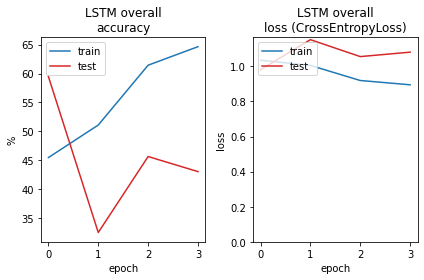

In [36]:
loss_fn = nn.CrossEntropyLoss().to("cuda")
optimizer = Adam(lstm_overall.parameters(), lr=0.01)

train_and_plot_lc(lstm_overall, "LSTM overall", overallTrainDataloader, overallTestDataloader, loss_fn, optimizer, epochs = 10)

In [37]:
lstm_overall.load_state_dict(torch.load(f"{DATA_DIR}LSTM overall-3.pth"))
metrics(lstm_overall, overallTestDataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test:  [    0/ 1036]
                precision    recall  f1-score   support

   rating <= 4       0.33      0.32      0.32       241
4 < rating < 7       0.11      0.28      0.16       125
   rating >= 7       0.68      0.50      0.58       670

      accuracy                           0.43      1036
     macro avg       0.37      0.37      0.35      1036
  weighted avg       0.53      0.43      0.47      1036



Accuracy: 0.4305019305019305
Balanced_accuracy: 0.3651175656984786
F1: 0.35304949805428415
Roc_auc: 0.5429990276705887
Precision: 0.3743119844360206
Recall: 0.3651175656984786


# Side effects

In [15]:
seTestDataset = DrugLib(DATA_DIR, train=False, task="sideEffects")
seTrainDataset = DrugLib(DATA_DIR, train=True, task="sideEffects")

seTestDataloader = DataLoader(seTestDataset, batch_size=64)
seTrainDataloader = DataLoader(seTrainDataset, sampler=seTrainDataset.sampler, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


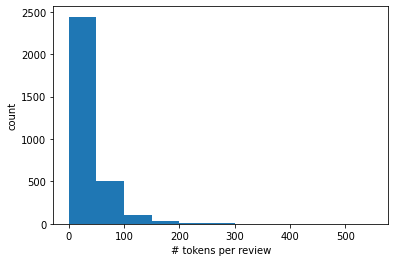

In [40]:
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in seTrainDataset.tokens], bins=range(0, 600, 50))
plt.show()

Reduce rewiews to 200 tokens

## RNN

In [16]:
embed_size, num_hiddens, num_layers = 100, 64, 2
rnn_se = BiRNN(len(seTrainDataset.vocab), embed_size, num_hiddens, num_layers, 3, nn.RNN).to("cuda")
initNet(rnn_se, seTrainDataset.vocab)

Epoch 1
-------------------------------
Memory allocated: 10.7 MB
Accuracy: 35.9%, Avg loss: 1.088464,	[   64/ 3096]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 53.4%, Avg loss: 1.034721,	[ 1344/ 3096]
Accuracy: 55.3%, Avg loss: 0.849628,	[ 2624/ 3096]
Train accuracy: 55.2%, Avg loss: 0.984958 
Memory allocated: 10.9 MB
Test loss: 1.136219  [    0/ 1036]
Test Error: 
 Accuracy: 42.5%, Avg loss: 1.088595 

Memory allocated: 10.9 MB
Validation loss decreased (inf --> 1.088595).  Saving model ...
Epoch 2
-------------------------------
Memory allocated: 10.9 MB
Accuracy: 59.4%, Avg loss: 0.943489,	[   64/ 3096]
Accuracy: 62.4%, Avg loss: 0.931104,	[ 1344/ 3096]
Accuracy: 61.1%, Avg loss: 0.870223,	[ 2624/ 3096]
Train accuracy: 61.8%, Avg loss: 0.923389 
Memory allocated: 10.9 MB
Test loss: 1.197353  [    0/ 1036]
Test Error: 
 Accuracy: 31.8%, Avg loss: 1.210202 

Memory allocated: 10.9 MB
EarlyStopping counter: 1 out of 3
Epoch 3
-------------------------------
Memory allocated: 10.9 MB
Accuracy: 67.2%, Avg loss: 0.881296,	[   64/ 3096]
Accuracy: 60.8%, Avg loss: 0.898967,	[ 1344/ 3096]
Accuracy: 59.7%, Avg loss: 0.965357,	[ 2624/ 3096

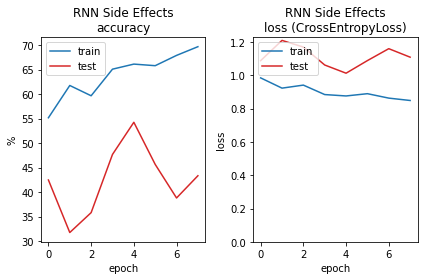

In [46]:
loss_fn = nn.CrossEntropyLoss().to("cuda")
optimizer = Adam(rnn_se.parameters(), lr=0.01)

train_and_plot_lc(rnn_se, "RNN Side Effects", seTrainDataloader, seTestDataloader, loss_fn, optimizer, epochs = 10)


In [17]:
rnn_se.load_state_dict(torch.load(f"{DATA_DIR}RNN Side Effects-4.pth"))
metrics(rnn_se, seTestDataloader, "sideEffects")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test:  [    0/ 1036]
                                       precision    recall  f1-score   support

                      No Side Effects       0.25      0.01      0.02       268
           Mild/Moderate Side Effects       0.55      0.98      0.70       566
Severe/Extremely Severe  Side Effects       0.40      0.02      0.04       202

                             accuracy                           0.54      1036
                            macro avg       0.40      0.34      0.25      1036
                         weighted avg       0.44      0.54      0.40      1036



Accuracy: 0.5424710424710425
Balanced_accuracy: 0.3371871270245003
F1: 0.2538986886849318
Roc_auc: 0.48702699577947023
Precision: 0.399112426035503
Recall: 0.3371871270245003


## GRU

In [18]:
embed_size, num_hiddens, num_layers = 100, 64, 2
gru_se = BiRNN(len(seTrainDataset.vocab), embed_size, num_hiddens, num_layers, 3, nn.GRU).to("cuda")
initNet(gru_se, seTrainDataset.vocab)

Epoch 1
-------------------------------
Memory allocated: 12.0 MB
Accuracy: 25.0%, Avg loss: 1.110427,	[   64/ 3096]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 61.2%, Avg loss: 0.893197,	[ 1344/ 3096]
Accuracy: 65.0%, Avg loss: 0.943275,	[ 2624/ 3096]
Train accuracy: 65.9%, Avg loss: 0.874549 
Memory allocated: 13.3 MB
Test loss: 1.026919  [    0/ 1036]
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.000553 

Memory allocated: 13.3 MB
Validation loss decreased (inf --> 1.000553).  Saving model ...
Epoch 2
-------------------------------
Memory allocated: 13.3 MB
Accuracy: 79.7%, Avg loss: 0.755625,	[   64/ 3096]
Accuracy: 73.3%, Avg loss: 0.801427,	[ 1344/ 3096]
Accuracy: 75.5%, Avg loss: 0.750719,	[ 2624/ 3096]
Train accuracy: 76.4%, Avg loss: 0.780505 
Memory allocated: 13.3 MB
Test loss: 1.028589  [    0/ 1036]
Test Error: 
 Accuracy: 53.4%, Avg loss: 1.002461 

Memory allocated: 13.3 MB
EarlyStopping counter: 1 out of 3
Epoch 3
-------------------------------
Memory allocated: 13.3 MB
Accuracy: 85.9%, Avg loss: 0.701500,	[   64/ 3096]
Accuracy: 75.0%, Avg loss: 0.727105,	[ 1344/ 3096]
Accuracy: 75.5%, Avg loss: 0.810951,	[ 2624/ 3096

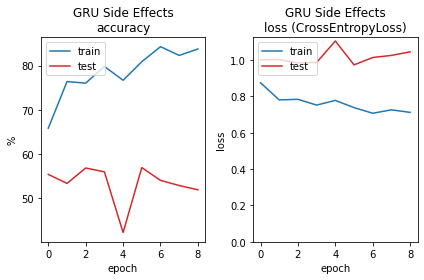

In [49]:
loss_fn = nn.CrossEntropyLoss().to("cuda")
optimizer = Adam(gru_se.parameters(), lr=0.01)

train_and_plot_lc(gru_se, "GRU Side Effects", seTrainDataloader, seTestDataloader, loss_fn, optimizer, epochs = 10)


In [19]:
gru_se.load_state_dict(torch.load(f"{DATA_DIR}GRU Side Effects-5.pth"))
metrics(gru_se, seTestDataloader, "sideEffects")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test:  [    0/ 1036]
                                       precision    recall  f1-score   support

                      No Side Effects       0.71      0.32      0.44       268
           Mild/Moderate Side Effects       0.59      0.80      0.68       566
Severe/Extremely Severe  Side Effects       0.35      0.26      0.30       202

                             accuracy                           0.57      1036
                            macro avg       0.55      0.46      0.47      1036
                         weighted avg       0.57      0.57      0.54      1036



Accuracy: 0.5694980694980695
Balanced_accuracy: 0.4600305159992293
F1: 0.4736605656943353
Roc_auc: 0.5957733605773098
Precision: 0.5512065395487855
Recall: 0.4600305159992293


## LSTM

In [20]:
embed_size, num_hiddens, num_layers = 100, 64, 2
lstm_se = BiRNN(len(seTrainDataset.vocab), embed_size, num_hiddens, num_layers, 3, nn.LSTM).to("cuda")
initNet(lstm_se, seTrainDataset.vocab)

Epoch 1
-------------------------------
Memory allocated: 14.6 MB
Accuracy: 20.3%, Avg loss: 1.102529,	[   64/ 3096]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 57.1%, Avg loss: 0.921775,	[ 1344/ 3096]
Accuracy: 59.6%, Avg loss: 0.915447,	[ 2624/ 3096]
Train accuracy: 60.9%, Avg loss: 0.914960 
Memory allocated: 15.7 MB
Test loss: 1.061439  [    0/ 1036]
Test Error: 
 Accuracy: 44.6%, Avg loss: 1.081625 

Memory allocated: 15.7 MB
Validation loss decreased (inf --> 1.081625).  Saving model ...
Epoch 2
-------------------------------
Memory allocated: 15.7 MB
Accuracy: 68.8%, Avg loss: 0.851956,	[   64/ 3096]
Accuracy: 67.6%, Avg loss: 0.831524,	[ 1344/ 3096]
Accuracy: 67.2%, Avg loss: 0.926914,	[ 2624/ 3096]
Train accuracy: 67.0%, Avg loss: 0.875072 
Memory allocated: 15.7 MB
Test loss: 1.000555  [    0/ 1036]
Test Error: 
 Accuracy: 51.4%, Avg loss: 1.041171 

Memory allocated: 15.7 MB
Validation loss decreased (1.081625 --> 1.041171).  Saving model ...
Epoch 3
-------------------------------
Memory allocated: 15.7 MB
Accuracy: 42.2%, Avg loss: 1.065834,	[   64/ 3096]
Accuracy: 64.7%, Avg loss: 0.932858,	[ 1344/ 3096]
Accuracy: 66.2

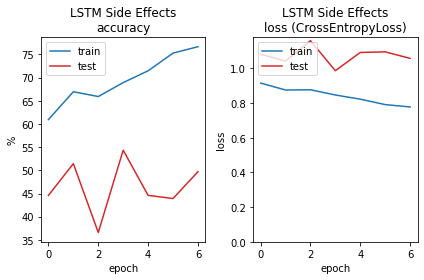

In [52]:
loss_fn = nn.CrossEntropyLoss().to("cuda")
optimizer = Adam(lstm_se.parameters(), lr=0.01)

train_and_plot_lc(lstm_se, "LSTM Side Effects", seTrainDataloader, seTestDataloader, loss_fn, optimizer, epochs = 10)


In [21]:
lstm_se.load_state_dict(torch.load(f"{DATA_DIR}LSTM Side Effects-3.pth"))
metrics(lstm_se, seTestDataloader, "sideEffects")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test:  [    0/ 1036]
                                       precision    recall  f1-score   support

                      No Side Effects       0.37      0.09      0.15       268
           Mild/Moderate Side Effects       0.56      0.94      0.70       566
Severe/Extremely Severe  Side Effects       0.60      0.03      0.06       202

                             accuracy                           0.54      1036
                            macro avg       0.51      0.35      0.30      1036
                         weighted avg       0.52      0.54      0.43      1036



Accuracy: 0.5434362934362934
Balanced_accuracy: 0.35430529366949676
F1: 0.30119200901774074
Roc_auc: 0.575507529199212
Precision: 0.5076568832125753
Recall: 0.35430529366949676


# Effectiveness

In [23]:
effTestDataset = DrugLib(DATA_DIR, train=False, task="effectiveness")
effTrainDataset = DrugLib(DATA_DIR, train=True, task="effectiveness")

effTestDataloader = DataLoader(effTestDataset, batch_size=64)
effTrainDataloader = DataLoader(effTrainDataset, sampler=effTrainDataset.sampler, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


## RNN

In [24]:
embed_size, num_hiddens, num_layers = 100, 64, 2
enn_eff = BiRNN(len(effTrainDataset.vocab), embed_size, num_hiddens, num_layers, 3, nn.RNN).to("cuda")
initNet(enn_eff, effTrainDataset.vocab)

Epoch 1
-------------------------------
Memory allocated: 0.9 MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 39.1%, Avg loss: 1.105502,	[   64/ 3096]
Accuracy: 44.8%, Avg loss: 1.001901,	[ 1344/ 3096]
Accuracy: 47.5%, Avg loss: 1.043089,	[ 2624/ 3096]
Train accuracy: 48.2%, Avg loss: 1.049822 
Memory allocated: 2.1 MB
Test loss: 1.373982  [    0/ 1036]
Test Error: 
 Accuracy: 19.5%, Avg loss: 1.343466 

Memory allocated: 2.1 MB
Validation loss decreased (inf --> 1.343466).  Saving model ...
Epoch 2
-------------------------------
Memory allocated: 2.1 MB
Accuracy: 50.0%, Avg loss: 1.040845,	[   64/ 3096]
Accuracy: 51.0%, Avg loss: 1.046938,	[ 1344/ 3096]
Accuracy: 50.8%, Avg loss: 1.148141,	[ 2624/ 3096]
Train accuracy: 50.8%, Avg loss: 1.033200 
Memory allocated: 2.1 MB
Test loss: 0.883898  [    0/ 1036]
Test Error: 
 Accuracy: 64.7%, Avg loss: 0.896579 

Memory allocated: 2.1 MB
Validation loss decreased (1.343466 --> 0.896579).  Saving model ...
Epoch 3
-------------------------------
Memory allocated: 2.1 MB
Accuracy: 51.6%, Avg loss: 1.035324,	[   64/ 3096]
Accuracy: 51.1%, Avg

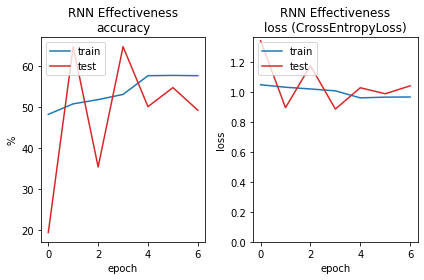

In [18]:
loss_fn = nn.CrossEntropyLoss().to("cuda")
optimizer = Adam(enn_eff.parameters(), lr=0.01)

train_and_plot_lc(enn_eff, "RNN Effectiveness", effTrainDataloader, effTestDataloader, loss_fn, optimizer, epochs = 10)

In [25]:
enn_eff.load_state_dict(torch.load(f"{DATA_DIR}RNN Effectiveness-5.pth"))
metrics(enn_eff, effTestDataloader, "effectiveness")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test:  [    0/ 1036]
                                 precision    recall  f1-score   support

                    Ineffective       0.05      0.06      0.05        82
Marginally/Moderately Effective       0.19      0.13      0.15       233
  Considerably/Highly Effective       0.69      0.74      0.71       721

                       accuracy                           0.55      1036
                      macro avg       0.31      0.31      0.31      1036
                   weighted avg       0.53      0.55      0.53      1036



Accuracy: 0.5472972972972973
Balanced_accuracy: 0.30919835074428914
F1: 0.3064842719282508
Roc_auc: 0.4722380828912614
Precision: 0.3093574559132572
Recall: 0.30919835074428914


## GRU

In [26]:
embed_size, num_hiddens, num_layers = 100, 64, 2
gru_eff = BiRNN(len(effTrainDataset.vocab), embed_size, num_hiddens, num_layers, 3, nn.GRU).to("cuda")
initNet(gru_eff, effTrainDataset.vocab)

Epoch 1
-------------------------------
Memory allocated: 5.8 MB
Accuracy: 25.0%, Avg loss: 1.105625,	[   64/ 3096]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 47.7%, Avg loss: 0.991089,	[ 1344/ 3096]
Accuracy: 54.1%, Avg loss: 0.895280,	[ 2624/ 3096]
Train accuracy: 55.9%, Avg loss: 0.953139 
Memory allocated: 4.6 MB
Test loss: 1.108323  [    0/ 1036]
Test Error: 
 Accuracy: 40.0%, Avg loss: 1.112786 

Memory allocated: 4.6 MB
Validation loss decreased (inf --> 1.112786).  Saving model ...
Epoch 2
-------------------------------
Memory allocated: 4.6 MB
Accuracy: 60.9%, Avg loss: 0.944273,	[   64/ 3096]
Accuracy: 64.9%, Avg loss: 0.994441,	[ 1344/ 3096]
Accuracy: 65.9%, Avg loss: 0.843754,	[ 2624/ 3096]
Train accuracy: 67.0%, Avg loss: 0.869929 
Memory allocated: 4.6 MB
Test loss: 0.927532  [    0/ 1036]
Test Error: 
 Accuracy: 57.5%, Avg loss: 0.949486 

Memory allocated: 4.6 MB
Validation loss decreased (1.112786 --> 0.949486).  Saving model ...
Epoch 3
-------------------------------
Memory allocated: 4.6 MB
Accuracy: 71.9%, Avg loss: 0.828612,	[   64/ 3096]
Accuracy: 69.9%, Avg loss: 0.754753,	[ 1344/ 3096]
Accuracy: 70.2%, Avg

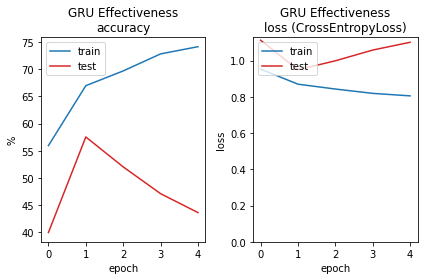

In [25]:
loss_fn = nn.CrossEntropyLoss().to("cuda")
optimizer = Adam(gru_eff.parameters(), lr=0.01)

train_and_plot_lc(gru_eff, "GRU Effectiveness", effTrainDataloader, effTestDataloader, loss_fn, optimizer, epochs = 10)

In [27]:
gru_eff.load_state_dict(torch.load(f"{DATA_DIR}GRU Effectiveness-2.pth"))
metrics(gru_eff, effTestDataloader, "effectiveness")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test:  [    0/ 1036]
                                 precision    recall  f1-score   support

                    Ineffective       0.03      0.01      0.02        82
Marginally/Moderately Effective       0.24      0.38      0.29       233
  Considerably/Highly Effective       0.72      0.62      0.67       721

                       accuracy                           0.52      1036
                      macro avg       0.33      0.34      0.33      1036
                   weighted avg       0.55      0.52      0.53      1036



Accuracy: 0.5202702702702703
Balanced_accuracy: 0.33897185224374665
F1: 0.32528708323433914
Roc_auc: 0.5420205574627731
Precision: 0.3278765656753979
Recall: 0.33897185224374665


## LSTM

In [28]:
embed_size, num_hiddens, num_layers = 100, 64, 2
lstm_eff = BiRNN(len(effTrainDataset.vocab), embed_size, num_hiddens, num_layers, 3, nn.LSTM).to("cuda")
initNet(lstm_eff, effTrainDataset.vocab)

Epoch 1
-------------------------------
Memory allocated: 6.0 MB
Accuracy: 34.4%, Avg loss: 1.099666,	[   64/ 3096]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 47.8%, Avg loss: 0.957095,	[ 1344/ 3096]
Accuracy: 49.5%, Avg loss: 0.972502,	[ 2624/ 3096]
Train accuracy: 50.2%, Avg loss: 1.002554 
Memory allocated: 7.1 MB
Test loss: 0.959916  [    0/ 1036]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.952329 

Memory allocated: 7.1 MB
Validation loss decreased (inf --> 0.952329).  Saving model ...
Epoch 2
-------------------------------
Memory allocated: 7.1 MB
Accuracy: 48.4%, Avg loss: 1.000004,	[   64/ 3096]
Accuracy: 57.1%, Avg loss: 0.967599,	[ 1344/ 3096]
Accuracy: 57.7%, Avg loss: 0.977767,	[ 2624/ 3096]
Train accuracy: 58.4%, Avg loss: 0.938512 
Memory allocated: 7.1 MB
Test loss: 1.145923  [    0/ 1036]
Test Error: 
 Accuracy: 36.0%, Avg loss: 1.116725 

Memory allocated: 7.1 MB
EarlyStopping counter: 1 out of 3
Epoch 3
-------------------------------
Memory allocated: 7.1 MB
Accuracy: 60.9%, Avg loss: 0.932400,	[   64/ 3096]
Accuracy: 58.2%, Avg loss: 0.947986,	[ 1344/ 3096]
Accuracy: 59.7%, Avg loss: 0.940588,	[ 2624/ 3096]
Trai

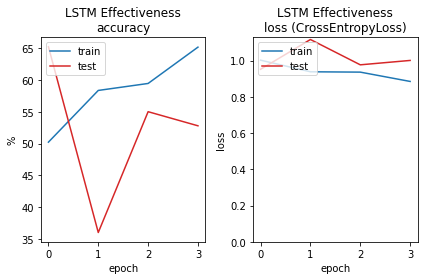

In [28]:
loss_fn = nn.CrossEntropyLoss().to("cuda")
optimizer = Adam(lstm_eff.parameters(), lr=0.01)

train_and_plot_lc(lstm_eff, "LSTM Effectiveness", effTrainDataloader, effTestDataloader, loss_fn, optimizer, epochs = 10)

In [29]:
lstm_eff.load_state_dict(torch.load(f"{DATA_DIR}LSTM Effectiveness-3.pth"))
metrics(lstm_eff, effTestDataloader, "effectiveness")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test:  [    0/ 1036]
                                 precision    recall  f1-score   support

                    Ineffective       0.05      0.04      0.04        82
Marginally/Moderately Effective       0.25      0.33      0.29       233
  Considerably/Highly Effective       0.70      0.65      0.67       721

                       accuracy                           0.53      1036
                      macro avg       0.33      0.34      0.33      1036
                   weighted avg       0.55      0.53      0.54      1036



Accuracy: 0.527992277992278
Balanced_accuracy: 0.33825632688237733
F1: 0.3334858326677897
Roc_auc: 0.5305651555944041
Precision: 0.33327135458283
Recall: 0.33825632688237733


# BERT (Extra)

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [16]:
class DrugLibBert(Dataset):
  def __init__(self, root, train, task):
    self.root = os.path.join(root, "drugLib") 
    self.task = task # overall | effectiveness | sideEffects

    self.download()

    if not self._check_integrity():
      raise RuntimeError("Dataset not found or corrupted.")

    self.load(train)

  def download(self) -> None:
    if self._check_integrity():
        print("Files already downloaded and verified")
        return

    download_and_extract_archive(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00461/drugLib_raw.zip",
        self.root,
        md5="b4f5b49c9ddb7b6f466928e1f49ad23f",
        filename="drugLib_raw.zip"
    )

  def _check_integrity(self) -> bool:
    return os.path.exists(os.path.join(self.root, "drugLibTrain_raw.tsv")) and os.path.exists(os.path.join(self.root, "drugLibTest_raw.tsv"))

  def load(self, train):
    if train:
      self.df = pd.read_csv(os.path.join(self.root, "drugLibTrain_raw.tsv"), sep="\t", header=0)
    else:
      self.df = pd.read_csv(os.path.join(self.root, "drugLibTest_raw.tsv"), sep="\t", header=0)

    self.df = self.df.dropna()


    effMap = {'Ineffective':0, 'Marginally Effective':1, 'Moderately Effective':1, 'Considerably Effective':2,
                         'Highly Effective':2}
    sideEffectsMap = {'No Side Effects':0, 'Mild Side Effects':1, 'Moderate Side Effects':1, 'Severe Side Effects':2, 'Extremely Severe Side Effects':2}

    self.df["rating"] = self.df["rating"].apply(lambda x: 0 if x <= 4 else (1 if x < 7 else 2))

    self.df["effectiveness"] = self.df["effectiveness"].apply(lambda x: effMap[x])
    self.df["sideEffects"] = self.df["sideEffects"].apply(lambda x: sideEffectsMap[x])

    if self.task == "overall":
      self.labels = self.df["rating"]
      self.data = self.df[["benefitsReview", "sideEffectsReview", "commentsReview"]].apply(lambda x: " ".join(x), axis=1)
    elif self.task == "effectiveness":
      self.labels = self.df["effectiveness"]
      self.data = self.df["benefitsReview"]
    elif self.task == "sideEffects":
      self.labels = self.df["sideEffects"]
      self.data = self.df["sideEffectsReview"]
    else:
      raise ValueError("Bad task!")


    encoded_data = tokenizer.batch_encode_plus(
        self.data.values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    self.input_ids = encoded_data['input_ids']
    self.attention_masks = encoded_data['attention_mask']

    self.labels = torch.tensor(self.labels.values)
  
  def __len__(self):
        return len(self.df)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attention_masks[idx], self.labels[idx]

In [34]:
class BertRNN(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        super(BertRNN, self).__init__()

        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.LSTM(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)



    def forward(self, inputs):
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(inputs)[0]

        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

## Overall

In [17]:
bertTestDataset = DrugLibBert(DATA_DIR, train=False, task="overall")
bertTrainDataset = DrugLibBert(DATA_DIR, train=True, task="overall")

bertTestDataloader = DataLoader(bertTestDataset, batch_size=16)
bertTrainDataloader = DataLoader(bertTrainDataset, batch_size=16)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [24]:
overallBert = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = 3,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     ).to("cuda")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
def train_loop_bert(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    total_loss = 0
    model.train()
    for batch, (input_ids, attention_mask, labels) in enumerate(dataloader):
        input_ids, attention_mask, labels = input_ids.to("cuda"), attention_mask.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        model.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        pred = outputs[1]

        loss.backward()
        optimizer.step()

        correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
        total_loss += float(loss.item())
        if batch % 20 == 0:
            loss, current = float(loss.item()), (batch +1) * len(input_ids)
            print(f"Accuracy: {(100 * correct / current):>0.1f}%, Avg loss: {loss:>7f},\t[{current:>5d}/{size:>5d}]")
    
    lossTrain = total_loss/len(dataloader)
    accuracyTrain = 100 * correct / size

    print(f"Train accuracy: {accuracyTrain:>0.1f}%, Avg loss: {lossTrain:>7f} ")

    print(f"Memory allocated: {(torch.cuda.memory_allocated()/1024/1024):.1f} MB")

    return lossTrain, accuracyTrain

In [21]:
def test_loop_bert(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        model.eval()
        for batch, (input_ids, attention_mask, labels) in enumerate(dataloader):
            input_ids, attention_mask, labels = input_ids.to("cuda"), attention_mask.to("cuda"), labels.to("cuda")

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs[0]
            pred = outputs[1]
            
            test_loss += float(loss.item())
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

            if batch % 20 == 0:
              loss, current = loss.item(), batch * len(input_ids)
              print(f"Test loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    test_loss /= num_batches
    correct /= size

    accuracyTest = 100 * correct

    print(f"Test Error: \n Accuracy: {accuracyTest:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Memory allocated: {(torch.cuda.memory_allocated()/1024/1024):.1f} MB")

    return test_loss, accuracyTest

In [32]:
def predict_bert(model, dataloader):
  y_pred = []
  y_true = []
  confidence = []

  size = len(dataloader.dataset)

  with torch.no_grad():
    model.eval()
    for batch, (input_ids, attention_mask, labels) in enumerate(dataloader):
        input_ids, attention_mask, labels = input_ids.to("cuda"), attention_mask.to("cuda"), labels.to("cuda")

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
        loss = outputs[0]
        pred = outputs[1]

        y_true.append(labels.cpu().numpy())
        y_pred_t = pred.argmax(1).cpu().numpy()

        y_pred.append(y_pred_t)
        confidence.append(softmax(pred).cpu().numpy())

        if batch % 20 == 0:
          current = batch * len(input_ids)
          print(f"Test:  [{current:>5d}/{size:>5d}]")

  y_pred = np.concatenate([i.squeeze() for i in y_pred])
  y_true = np.concatenate([i.squeeze() for i in y_true])
  confidence = np.concatenate([i.squeeze() for i in confidence])

  return y_pred, y_true, confidence

Epoch 1
-------------------------------
Memory allocated: 2174.7 MB
Accuracy: 6.2%, Avg loss: 1.254197,	[   16/ 3096]
Accuracy: 46.1%, Avg loss: 1.521045,	[  336/ 3096]
Accuracy: 57.2%, Avg loss: 0.924126,	[  656/ 3096]
Accuracy: 57.6%, Avg loss: 1.027710,	[  976/ 3096]
Accuracy: 57.2%, Avg loss: 1.850906,	[ 1296/ 3096]
Accuracy: 57.2%, Avg loss: 1.772797,	[ 1616/ 3096]
Accuracy: 56.8%, Avg loss: 1.338751,	[ 1936/ 3096]
Accuracy: 57.0%, Avg loss: 2.110138,	[ 2256/ 3096]
Accuracy: 57.1%, Avg loss: 2.231029,	[ 2576/ 3096]
Accuracy: 56.8%, Avg loss: 1.966668,	[ 2896/ 3096]
Train accuracy: 56.3%, Avg loss: 1.369383 
Memory allocated: 3472.5 MB
Test loss: 2.446530  [    0/ 1036]
Test loss: 2.003143  [  320/ 1036]
Test loss: 3.350206  [  640/ 1036]
Test loss: 1.116368  [  960/ 1036]
Test Error: 
 Accuracy: 64.7%, Avg loss: 2.088371 

Memory allocated: 3472.5 MB
Validation loss decreased (inf --> 2.088371).  Saving model ...
Epoch 2
-------------------------------
Memory allocated: 3472.4 MB


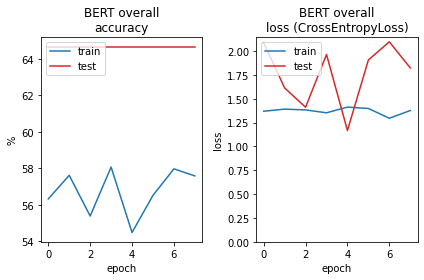

In [26]:
optimizer = Adam(overallBert.parameters(), lr=0.01)

train_and_plot_lc(overallBert, "BERT overall", bertTrainDataloader, bertTestDataloader, None, optimizer, 10, train_loop_bert, test_loop_bert)

In [33]:
overallBert.load_state_dict(torch.load(f"{DATA_DIR}BERT overall-4.pth"))
metrics(overallBert, bertTestDataloader, "overall", predict_bert)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test:  [    0/ 1036]
Test:  [  320/ 1036]
Test:  [  640/ 1036]
Test:  [  960/ 1036]
                precision    recall  f1-score   support

   rating <= 4       0.00      0.00      0.00       241
4 < rating < 7       0.00      0.00      0.00       125
   rating >= 7       0.65      1.00      0.79       670

      accuracy                           0.65      1036
     macro avg       0.22      0.33      0.26      1036
  weighted avg       0.42      0.65      0.51      1036



Accuracy: 0.6467181467181468
Balanced_accuracy: 0.3333333333333333
F1: 0.2618210238374365
Roc_auc: 0.5
Precision: 0.2155727155727156
Recall: 0.3333333333333333


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat